# 사전 작업

In [1]:
# importing packages

# 기본 패키지

from google.colab import drive
import pandas as pd
import numpy as np
import warnings

# Future warning 무시

warnings.filterwarnings("ignore", category=FutureWarning)

# 시각화 패키지

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 데이터 분석 패키지

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings

In [2]:
# 항상 저장할 것...

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 한글 폰트 다운로드

!sudo apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
plt.rc("font", family="NanumGothic")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [4]:
# 데이터 업로드

train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

# original gangstar

train.og = train.copy()

<ipython-input-4-3abbc6030058>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train.og = train.copy()


# 결측치 처리

In [5]:
def transform(data, is_train=True, fill_values=None):
    # 원본 데이터 수정 방지: 복사본 사용
    data = data.copy()

    # 0. NA여부 변수 생성: 각 행별로 조건에 따라 라벨 부여
    def assign_na_label(row):
        if row["월세"] == 0:
            return 3
        elif pd.isnull(row["방수"]) or pd.isnull(row["해당층"]) or pd.isnull(row["욕실수"]) or pd.isnull(row["총층"]):
            return 2
        elif pd.isnull(row["전용면적"]) or pd.isnull(row["총주차대수"]):
            return 1
        else:
            return 0

    data["NA여부"] = data.apply(assign_na_label, axis=1)

    if is_train:
        # 1. '전용면적' 결측값: 중앙값 대체
        med_전용면적 = data["전용면적"].median()
        data["전용면적"].fillna(med_전용면적, inplace=True)

        # 2. '총층' 결측값: 중앙값 대체
        med_총층 = data["총층"].median()
        data["총층"].fillna(med_총층, inplace=True)

        # 3. '해당층' 결측값: 총층 값을 기반으로 1 ~ 총층 사이의 랜덤 값으로 대체
        na_indices = data["해당층"].isna()
        data.loc[na_indices, "해당층"] = data.loc[na_indices, "총층"].apply(lambda x: np.random.randint(1, x+1))

        # 4. '욕실수', '방수' 결측값: 최빈값(mode) 대체
        mode_욕실수 = data["욕실수"].mode()[0]
        data["욕실수"].fillna(mode_욕실수, inplace=True)
        mode_방수 = data["방수"].mode()[0]
        data["방수"].fillna(mode_방수, inplace=True)

        # 5. '총주차대수' 처리
        # 5.1. '주차가능여부'가 '불가능'이면 총주차대수를 0으로 설정
        data.loc[data["주차가능여부"] == "불가능", "총주차대수"] = 0
        # 5.2. 나머지 결측값: 총층을 predictor로 회귀 모델 이용
        valid_data = data.dropna(subset=["총주차대수", "총층"])
        X_data = valid_data[["총층"]].values
        y_data = valid_data["총주차대수"].values
        from sklearn.linear_model import LinearRegression
        lr_model = LinearRegression()
        lr_model.fit(X_data, y_data)
        missing_data = data[data["총주차대수"].isna()]
        if not missing_data.empty:
            X_missing = missing_data[["총층"]].values
            data.loc[data["총주차대수"].isna(), "총주차대수"] = np.round(lr_model.predict(X_missing))

        # 6. '월세' 처리: 월세가 0인 경우, 월세가 0이 아닌 관측값들의 평균으로 대체
        mean_월세 = data.loc[data["월세"] != 0, "월세"].mean()
        data.loc[data["월세"] == 0, "월세"] = mean_월세

        # 반환을 위해, 계산한 값들을 fill_values 사전으로 구성
        fill_values = {
            "med_전용면적": med_전용면적,
            "med_총층": med_총층,
            "mode_욕실수": mode_욕실수,
            "mode_방수": mode_방수,
            "lr_model": lr_model,
            "mean_월세": mean_월세
        }
        return data, fill_values

    else:
        # test set: train에서 계산한 fill_values를 사용해 대체
        if fill_values is None:
            raise ValueError("Test set imputation requires fill_values computed from train set.")

        data["전용면적"].fillna(fill_values["med_전용면적"], inplace=True)
        data["총층"].fillna(fill_values["med_총층"], inplace=True)
        na_indices = data["해당층"].isna()
        data.loc[na_indices, "해당층"] = data.loc[na_indices, "총층"].apply(lambda x: np.random.randint(1, x+1))
        data["욕실수"].fillna(fill_values["mode_욕실수"], inplace=True)
        data["방수"].fillna(fill_values["mode_방수"], inplace=True)
        data.loc[data["주차가능여부"] == "불가능", "총주차대수"] = 0
        missing_data = data[data["총주차대수"].isna()]
        if not missing_data.empty:
            X_missing = missing_data[["총층"]].values
            data.loc[data["총주차대수"].isna(), "총주차대수"] = np.round(fill_values["lr_model"].predict(X_missing))
        data.loc[data["월세"] == 0, "월세"] = fill_values["mean_월세"]
        return data

In [6]:
# 결측치 처리
train = transform(train, is_train=True)[0]
train_fill_values = transform(train, is_train=True)[1]

# Test set 처리: 반드시 train에서 계산한 fill_values를 사용합니다.
test = transform(test, is_train=False, fill_values=train_fill_values)

# training set만: outlier drop
train = train[~((train["총주차대수"] == 590) | ((train["총주차대수"] > 120) & (train["총층"] < 10)))]
train = train[train.관리비 < 40]

# 다른 outlier 들도 확인
# EDA 에서 확인 완료! (총주차대수, 관리비만 극심한 outlier 들 존재)

# 중개사무소를 어떻게 인코딩해주는 게 좋을까?

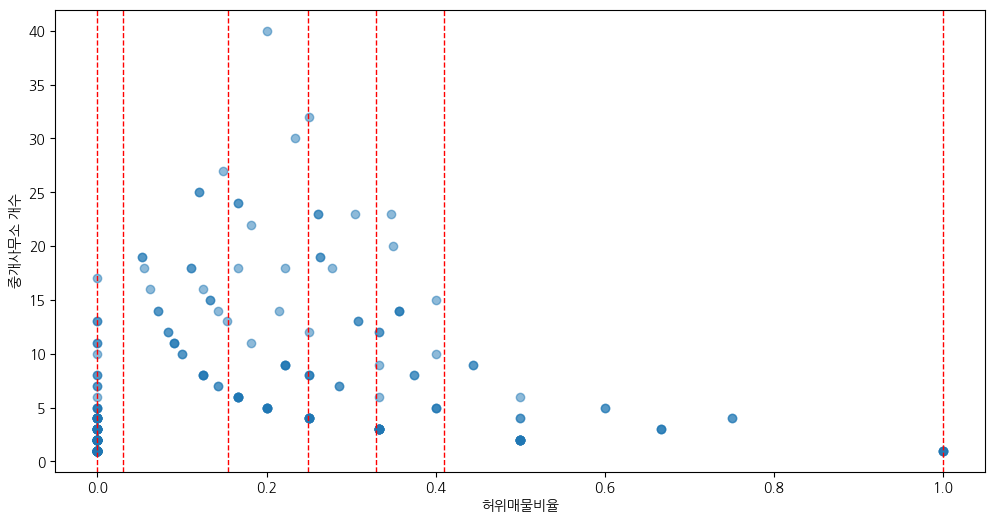

In [ ]:
# 1. 중개사무소별 허위매물비율, 거래량 분포

alpha = 1.5

df = train.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
df['허위매물비율'] = (df['sum'] + alpha) / (df['count'] + 2 * alpha) # 허위매물비율 보정 (smoothing)
df = df[df['count'] < 400] # 0티어 중개사무소 제외

# 중개사무소별 허위매물비율 vs Count scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(df['허위매물비율'], df['count'], alpha=0.5)
plt.xlabel('허위매물비율')
plt.ylabel('중개사무소 개수')

# 신뢰등급 수직선 추가
bins = [0, 0.03, 0.154, 0.249, 0.33, 0.41, 1]
x_vals = bins
for x in x_vals:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1)

# clustering 이 쉽지는 않을듯

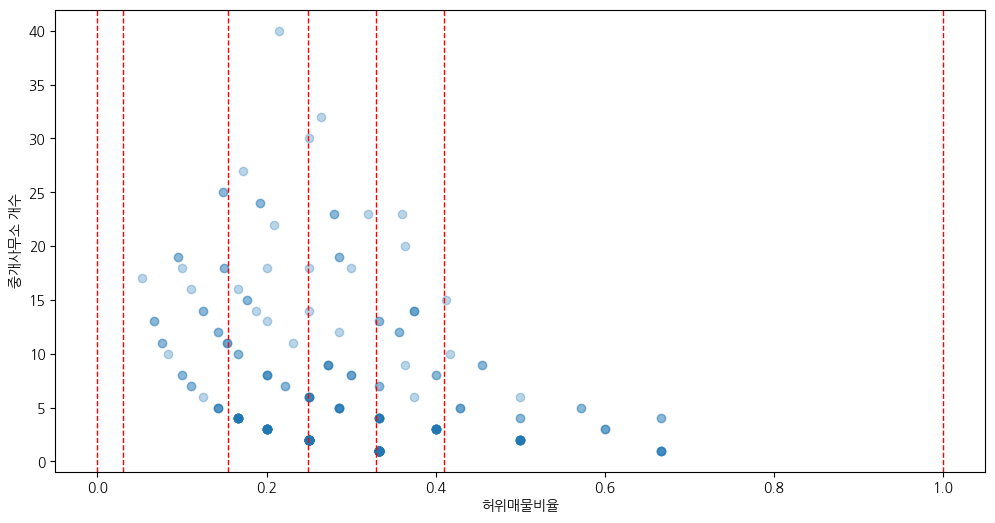

In [ ]:
# 1. 신뢰등급 (6등급) 사용

df = train.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
df['허위매물비율'] = (df['sum'] + 1) / (df['count'] + 2)
df = df[df['count'] < 400] # 0티어 중개사무소 제외

# 중개사무소별 허위매물비율 vs Count scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(df['허위매물비율'], df['count'], alpha=0.3)
plt.xlabel('허위매물비율')
plt.ylabel('중개사무소 개수')

# 신뢰등급 수직선 추가
bins = [0, 0.03, 0.154, 0.249, 0.33, 0.41, 1]
x_vals = bins
for x in x_vals:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=1)


# clustering 이 쉽지는 않을듯 (광일씨: kmeans 이용 clustering, target encoding 그런데 clustering 시
# 다른 변수들도 고려할 필요가 있나? 하는 의문)

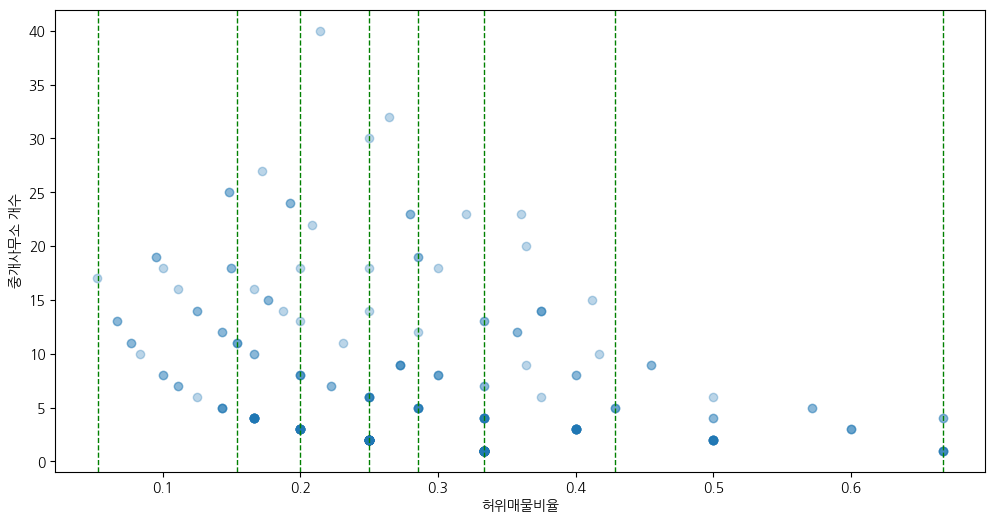

In [ ]:
# 2. 신뢰등급(8등급) 사용

# 중개사무소별 허위매물비율 vs Count scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(df['허위매물비율'], df['count'], alpha=0.3)
plt.xlabel('허위매물비율')
plt.ylabel('중개사무소 개수')

quantiles = np.quantile(df['허위매물비율'], np.linspace(0, 1, 11))
quantiles = np.unique(quantiles)
bins_two = list(quantiles + 0.0001)
x_vals_2 = bins_two
for x in x_vals_2:
    plt.axvline(x=x, color='green', linestyle='--', linewidth=1)

# 0.874 기록

In [ ]:
# 허위매물비율, 거래량을 동시에 사용한다면?

alpha = 0
df = train.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
df['허위매물비율'] = (df['sum'] + alpha) / (df['count'] + 2 * alpha)
df = df[df['count'] < 400] # 0티어 중개사무소 제외

# 중개사무소별 허위매물비율 vs Count scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(df['허위매물비율'], df['count'], alpha=0.3)
plt.xlabel('허위매물비율')
plt.ylabel('중개사무소 개수')

for x in np.linspace(0, 0.7, 12):
    plt.axvline(x=x, color='green', linestyle='--', linewidth=1)

for y in np.linspace(0, 10, 11):
    plt.axhline(y=y, color='blue', linestyle='--', linewidth=1)

# 이대로 사용하면 어떨까?
# alpha 값을 바꿔가면서 진행했는데 validation score 매우 낮게 나왔지만 (0.895) test score 은 낮음 (0.85)
# NA 값을 제대로 처리하지 못한다고 생각.

KeyError: '중개사무소'

# 중개사무소 허위매물비율 & 거래량 직접 사용

In [ ]:
# 중개사무소_허위매물비율 & 중개사무소_거래량 피처 직접 사용

# 게재일수
max_date = pd.to_datetime(train.게재일.max())

def feature_transform(data, is_train=True, one_hot_encoder=None, df = None):
    # 'ID' 변수 drop
    data.drop(columns='ID', inplace=True)

    # '게재일수' 변수 추가 ('게재일' 변수 drop)
    data['게재일수'] = (max_date - pd.to_datetime(data['게재일'])).dt.days # 만약 minus 이면?
    # 게재일수가 음수인 경우, 0으로 대체
    data.loc[data['게재일수'] < 0, '게재일수'] = 0
    data.drop(columns='게재일', inplace=True)

    # '주차가능여부' 변수 drop
    data.drop(columns = '주차가능여부', inplace = True)

    # 추가: 총주차대수 log 변환: skewedness 제거 위해
    data['총주차대수'] = np.log1p(data['총주차대수'])

    # '해당층' 변수 drop
    data.drop(columns = '해당층', inplace = True)
    # data.drop(columns = '욕실수', inplace = True)
    # Random Forest는 다중공산성에 robust 하므로 남겨두자.

    if is_train:
        # 희소한 '제공플랫폼' 클래스 처리 (등장 비율 2% 미만은 '기타'로 변경 - 원핫인코딩 시 범주가 너무 많아져, 차원을 줄이기 위함) # 2% 로 변경
        threshold = 0.02
        category_counts = data['제공플랫폼'].value_counts(normalize=True)
        rare_categories = category_counts[category_counts < threshold].index
        data['제공플랫폼'] = data['제공플랫폼'].replace(rare_categories, '기타')

        # 원 핫 인코딩 적용할 컬럼
        one_hot_cols = ['방향', '매물확인방식', '제공플랫폼']
        one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        encoded_array = one_hot_encoder.fit_transform(data[one_hot_cols])

    else:
        # Test 데이터: train에서 학습한 one_hot_encoder를 그대로 사용
        one_hot_cols = ['방향', '매물확인방식', '제공플랫폼']
        encoded_array = one_hot_encoder.transform(data[one_hot_cols])

    # 변환된 데이터를 DataFrame으로 변환
    encoded_col_names = one_hot_encoder.get_feature_names_out(one_hot_cols)
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=data.index)

    # 기존 범주형 컬럼 삭제 후 변환된 데이터 합치기
    data.drop(columns=one_hot_cols, inplace=True)
    data = pd.concat([data, encoded_df], axis=1)

    # 중개사무소 라벨 인코딩
    # 1. 허위매물 비율 laplace rule of succession 사용하여 보정
    # 2. 허위매물 비율 활용해 신뢰등급 나누기
    # 3. 라벨 인코딩
    if is_train:
      agency_stats = data.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
      # Laplace Smoothing 적용 (s = 허위매물 개수, n = 전체 개수)
      alpha = 0
      agency_stats['허위매물_비율'] = (agency_stats['sum'] + alpha) / (agency_stats['count'] + 2 * alpha)
      data = data.merge(agency_stats[['허위매물_비율', 'count']], left_on='중개사무소', right_index=True, how='left')
      # encoded_value = data['허위매물_비율'].mean() # train set mean 으로 대체 or 거래량 < 3 인 경우도 합리적!
    else:
      data = data.merge(df[['허위매물_비율', 'count']], left_on='중개사무소', right_index=True, how='left')
      # data['count'] = data['count'].fillna(1) # 최솟값 사용
      # data['허위매물_비율'] = data['허위매물_비율'].fillna(encoded_value)
    # 기존 '중개사무소' 변수 제거 (필요 시)
    data.rename(columns={"count": "중개사무소_거래량", "허위매물_비율": "중개사무소_허위매물비율"}, inplace=True)
    data.drop(columns=['중개사무소'], inplace=True)
    return (data, one_hot_encoder, agency_stats) if is_train else data

In [ ]:
# Test set 의 missing values 를 random forest classifier 를 이용하여 예측
# training set 에서 나머지 feature 들을 활용해서 train - impute
# 모델은 train set 만 사용한다는 점 유의

# 1. Train 데이터 전처리 (전체 feature_transform 수행)
train, one_hot_encoder, agency_stats = feature_transform(train, is_train=True)

# 2. Imputation Model 학습 (Train 데이터 사용)
# 대상 피처: '중개사무소_허위매물비율'와 '중개사무소_거래량'
# Predictor: train_transformed에서 두 대상 피처를 제외한 모든 피처
predictor_cols = [col for col in train.columns if col not in ['허위매물여부', '중개사무소_허위매물비율', '중개사무소_거래량']]

X_train_impute = train[predictor_cols]
y_train_ratio = train['중개사무소_허위매물비율']
y_train_count = train['중개사무소_거래량']

from sklearn.ensemble import RandomForestRegressor

rf_ratio = RandomForestRegressor(random_state=42)
rf_ratio.fit(X_train_impute, y_train_ratio)

rf_count = RandomForestRegressor(random_state=42)
rf_count.fit(X_train_impute, y_train_count)

# ---------------------------
# 3. Test 데이터 전처리
# feature_transform()를 test 데이터에 동일하게 적용.
# df 인자는 train_transformed를 넘겨서 merge 기준으로 사용.
test = feature_transform(test, is_train=False, one_hot_encoder=one_hot_encoder, df=agency_stats)
# ---------------------------
# 4. Test 데이터 imputation
# test_transformed에서 '중개사무소_허위매물비율'과 '중개사무소_거래량'이 NA인 행 찾기
mask = test['중개사무소_허위매물비율'].isna() & test['중개사무소_거래량'].isna()

missing_test = test[mask]
complete_test = test[~mask]

# imputation을 위한 predictor feature 추출 (동일 predictor_cols 사용)
X_test_impute = missing_test[predictor_cols]

# 예측 수행
predicted_ratio = rf_ratio.predict(X_test_impute)
predicted_count = rf_count.predict(X_test_impute)

# test_transformed의 NA 부분 채우기
test.loc[mask, '중개사무소_허위매물비율'] = predicted_ratio
test.loc[mask, '중개사무소_거래량'] = predicted_count

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# 이건 Randomforestclassifier 을 이용한 imputation 을 사용하지 않고 단순 대체를 사용할 경우 (위 코드의 encoded_value 사용)
# 허위매물비율, 거래량 사용 시

#train, one_hot_encoder, agency_stats = feature_transform(train, is_train= True)
#test = feature_transform(test, is_train=False,
#                         one_hot_encoder=one_hot_encoder,
#                         df = agency_stats)

# test.isnull().sum()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,0
보증금,0
월세,0
전용면적,0
총층,0
방수,0
욕실수,0
총주차대수,0
관리비,0
NA여부,0
게재일수,0


# Smoothing을 활용한 신뢰등급 사용

In [7]:
# Computing bins: 신뢰등급 기준

# alpha (보정 정도 하이퍼파라미터) : optuna 에 추가시켜서 최적화 진행할 수 있음 (xgboost_alpha 참고),
# 적절한 값 대입 (xgboost_alpha 결과 1.5 ~ 2 사이 값 선호되지만 '허위매물비율'을 최대한 보정없이 유지하려면 1.0이나 그보다 작은 값 사용)
# alpha = 1.5, 기존 결측치 처리 방법을 도입했을 때 0.8871 성능이 나왔는데, 다시 시도했을 때는 그만큼 안나오는중.. (결측치 처리 방식, 전처리 방식을 개선하면 성능을 높일 수 있지 않을까)

alpha = 1.5

data = train
agency_stats = data.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
# Laplace Smoothing 적용 (s = 허위매물 개수, n = 전체 개수)

agency_stats['허위매물비율'] = (agency_stats['sum'] + alpha) / (agency_stats['count'] + 2 * alpha)
data = data.merge(agency_stats[['허위매물비율']], left_on='중개사무소', right_index=True, how='left')
quantiles = np.quantile(data['허위매물비율'], np.linspace(0, 1, 11))
quantiles = np.unique(quantiles)
bins = [-1] + list(quantiles + 0.0001)
bins

[-1,
 0.0019703241895261845,
 0.14715882352941176,
 0.1924076923076923,
 0.22103023255813953,
 0.2885615384615384,
 0.3126,
 0.3751,
 0.6429571428571429]

In [8]:
# 신뢰등급 지정 (8등급까지)
# 게재일수
max_date = pd.to_datetime(train.게재일.max())

def feature_transform(data, is_train=True, one_hot_encoder=None, label_encoder= None, df = None, bins = None, alpha = alpha):
    # 'ID' 변수 drop
    data.drop(columns='ID', inplace=True)

    # '게재일수' 변수 추가 ('게재일' 변수 drop)
    data['게재일수'] = (max_date - pd.to_datetime(data['게재일'])).dt.days # 만약 minus 이면?
    # 게재일수가 음수인 경우, 0으로 대체
    data.loc[data['게재일수'] < 0, '게재일수'] = 0
    # '게재일수' 주별로 인코딩 (성능이 떨어짐)
    # 예시: train_transformed 데이터프레임에 '게재일수' 컬럼이 있다고 가정합니다.
    # max_days = data['게재일수'].max()
    # 7일 단위의 bin 경계를 생성합니다.
    # bins_day = np.arange(0, max_days + 7, 7)
    # 각 구간에 대한 라벨 (범주형 값)
    # labels = [f"Week {i}" for i in range(1, len(bins_day))]
    # '게재일수'를 주별로 구간화하여 '게재일수_주별' 생성 (범주형 변수)
    # data['게재일수_주별'] = pd.cut(data['게재일수'], bins=bins_day, labels=labels, include_lowest=True)
    # 범주형 '게재일수_주별'을 순서 정보를 보존한 정수형 값으로 변환
    # data['게재일수_주별'] = data['게재일수_주별'].cat.codes + 1  # +1을 해서 1부터 시작
    data.drop(columns=['게재일'], inplace=True)

    # '주차가능여부' 변수 drop
    data.drop(columns = '주차가능여부', inplace = True)

    # 추가: 총주차대수 log 변환: skewedness 제거 위해
    data['총주차대수'] = np.log1p(data['총주차대수'])

    # '해당층' 변수 drop
    data.drop(columns = '해당층', inplace = True)
    # data.drop(columns = '방수', inplace = True)
    # Random Forest는 다중공산성에 robust 하므로 남겨두자.

    # '욕실수' 변수 drop
    data.drop(columns = '욕실수', inplace = True)

    if is_train:
        # 희소한 '제공플랫폼' 클래스 처리 (등장 비율 2% 미만은 '기타'로 변경 - 원핫인코딩 시 범주가 너무 많아져, 차원을 줄이기 위함) # 2% 로 변경
        threshold = 0.02
        category_counts = data['제공플랫폼'].value_counts(normalize=True)
        rare_categories = category_counts[category_counts < threshold].index
        data['제공플랫폼'] = data['제공플랫폼'].replace(rare_categories, '기타')

        # 원 핫 인코딩 적용할 컬럼
        one_hot_cols = ['방향', '매물확인방식', '제공플랫폼']
        one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        encoded_array = one_hot_encoder.fit_transform(data[one_hot_cols])

    else:
        # Test 데이터: train에서 학습한 one_hot_encoder를 그대로 사용
        one_hot_cols = ['방향', '매물확인방식', '제공플랫폼']
        encoded_array = one_hot_encoder.transform(data[one_hot_cols])

    # 변환된 데이터를 DataFrame으로 변환
    encoded_col_names = one_hot_encoder.get_feature_names_out(one_hot_cols)
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=data.index)

    # 기존 범주형 컬럼 삭제 후 변환된 데이터 합치기
    data.drop(columns=one_hot_cols, inplace=True)
    data = pd.concat([data, encoded_df], axis=1)

    # 중개사무소 라벨 인코딩
    # 1. 허위매물 비율 laplace rule of succession 사용하여 보정
    # 2. 허위매물 비율 활용해 신뢰등급 나누기
    # 3. 라벨 인코딩
    if is_train:
      agency_stats = data.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
      # Laplace Smoothing 적용 (s = 허위매물 개수, n = 전체 개수)

      # alpha: bins를 정할 때 사용한 alpha 값과 동일
      alpha = 1.5
      agency_stats['허위매물비율'] = (agency_stats['sum'] + alpha) / (agency_stats['count'] + 2 * alpha)
      # 신뢰등급 기준 정의 (허위매물 비율이 낮을수록 높은 등급)
      bins = bins # 구간 설정: 최대한 고르게, 변화를 잘 드러내게
      labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 등급 (낮을수록 신뢰도 높음)
      # 허위매물 비율을 바탕으로 신뢰등급 부여
      agency_stats['신뢰등급'] = pd.cut(agency_stats['허위매물비율'], bins=bins, labels=labels)
      # 원본 데이터에 확률 값 추가
      data = data.merge(agency_stats[['신뢰등급']], left_on='중개사무소', right_index=True, how='left')
      # 신뢰등급 기준 라벨 매핑
      category = np.arange(1, 9)
      label_encoder = OrdinalEncoder(categories = [category],
                        handle_unknown='use_encoded_value', unknown_value= -1) # 아래 코드 때문에 필요없지만
      data['신뢰등급'] = label_encoder.fit_transform(data[['신뢰등급']])
    else:
      data = data.merge(df[['신뢰등급']], left_on='중개사무소', right_index=True, how='left')
      # 새로운 중개사무소가 나올 경우 ?등급으로 (5등급, 6등급, 7등급)
      data['신뢰등급'] = data['신뢰등급'].fillna(7)
      # data['count'] = data['count'].fillna(1) # 0 or 1
      data['신뢰등급'] = label_encoder.transform(data[['신뢰등급']])
    # 기존 '중개사무소' 변수 제거 (필요 시)
    data.drop(columns=['중개사무소'], inplace=True)
    return (data, one_hot_encoder, label_encoder, agency_stats) if is_train else data

In [9]:
# 신뢰등급, 라벨 인코딩 사용 시
train, one_hot_encoder, label_encoder, agency_stats = feature_transform(train, is_train= True, bins = bins, alpha = alpha)
test = feature_transform(test, is_train=False,
                         one_hot_encoder=one_hot_encoder, label_encoder=label_encoder,
                         df = agency_stats, alpha = alpha)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


<Axes: xlabel='신뢰등급', ylabel='count'>

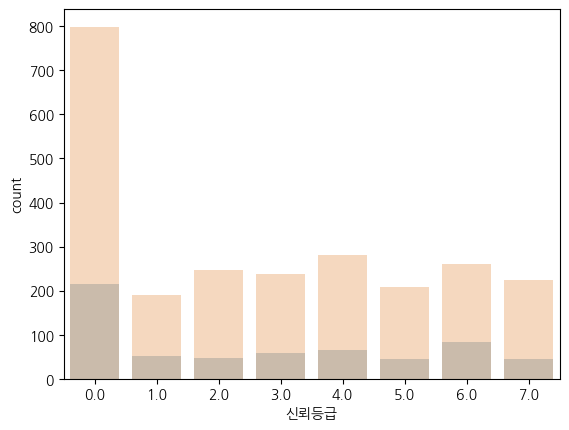

In [10]:
sns.countplot(data = test, x = '신뢰등급', alpha = 0.3)
sns.countplot(data = train, x = '신뢰등급', alpha = 0.3)

# Optuna 를 활용한 xgboost hyperparameter tuning

In [ ]:
!pip install optuna

In [ ]:
import optuna

# 특징(X)와 타겟(y) 분리
X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']

# 데이터 불균형 처리: scale_pos_weight 계산 (다수 클래스 / 소수 클래스)
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

def objective_repeated(trial):
    # 하이퍼파라미터 설정
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
        "scale_pos_weight": scale_pos_weight,
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
    }
    # num_boost_round도 최적화 대상
    num_boost_round = trial.suggest_int("num_boost_round", 100, 1000)

    # Repeated Stratified K-Fold: 5 folds, 3 repeats
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = []

    for train_idx, valid_idx in rskf.split(X, y):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dvalid_cv = xgb.DMatrix(X_valid_cv, label=y_valid_cv)

        early_stopping = EarlyStopping(rounds=10, data_name="validation")
        model = xgb.train(
            params=params,
            dtrain=dtrain_cv,
            num_boost_round=num_boost_round,
            evals=[(dvalid_cv, "validation")],
            callbacks=[early_stopping],
            verbose_eval=False
        )
        y_pred = (model.predict(dvalid_cv) > 0.5).astype(int)
        score = f1_score(y_valid_cv, y_pred)
        scores.append(score)

    return np.mean(scores)

# Optuna 최적화 실행 (Trial 수 100회) # 150회, 200회
study_repeated = optuna.create_study(direction="maximize")
study_repeated.optimize(objective_repeated, n_trials= 100)
print("Best hyperparameters (Repeated CV):", study_repeated.best_params)

[I 2025-02-24 03:24:47,132] A new study created in memory with name: no-name-b35042f5-b65d-498f-b506-38ae0eac4361


scale_pos_weight: 7.21


[I 2025-02-24 03:24:50,873] Trial 0 finished with value: 0.8289668167034244 and parameters: {'max_depth': 9, 'learning_rate': 0.15166911695081334, 'subsample': 0.890966665870665, 'colsample_bytree': 0.6368294362614901, 'gamma': 4.1937455613885355, 'reg_alpha': 2.444751681267599, 'reg_lambda': 3.012858357831126, 'min_child_weight': 1, 'num_boost_round': 994}. Best is trial 0 with value: 0.8289668167034244.
[I 2025-02-24 03:24:52,679] Trial 1 finished with value: 0.8463932043162515 and parameters: {'max_depth': 11, 'learning_rate': 0.10674771040615012, 'subsample': 0.8717777323623289, 'colsample_bytree': 0.8495690792012186, 'gamma': 4.35856566857349, 'reg_alpha': 0.4112335351991342, 'reg_lambda': 3.254932874334933, 'min_child_weight': 8, 'num_boost_round': 145}. Best is trial 1 with value: 0.8463932043162515.
[I 2025-02-24 03:24:56,358] Trial 2 finished with value: 0.8145795431483716 and parameters: {'max_depth': 3, 'learning_rate': 0.06287727633654143, 'subsample': 0.6632073711949699, '

Best hyperparameters (Repeated CV): {'max_depth': 12, 'learning_rate': 0.03679445537398491, 'subsample': 0.9481522155068092, 'colsample_bytree': 0.7140890236003863, 'gamma': 0.35327977231504254, 'reg_alpha': 0.3385621406303103, 'reg_lambda': 1.5059701006788124, 'min_child_weight': 3, 'num_boost_round': 235}


In [ ]:
# Optuna 최적화 결과에서 최적의 파라미터 추출
best_params = study_repeated.best_params.copy()

# 최적화 함수에서 포함한 num_boost_round를 별도로 추출
num_boost_round = best_params.pop("num_boost_round")

# 필요한 파라미터를 추가 (평가 지표와 불균형 처리)
best_params["eval_metric"] = "logloss"
best_params["scale_pos_weight"] = scale_pos_weight

# 전체 train 데이터를 사용하여 최종 모델 학습
# 여기서는 전체 train 데이터(X, y)를 사용합니다.
# X = train.drop(columns=["허위매물여부"])
# y = train["허위매물여부"]
dtrain = xgb.DMatrix(X, label=y)

# 최종 모델 학습 (Early Stopping은 선택 사항입니다. hold-out set이 있다면 추가할 수 있습니다)
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    verbose_eval=True
)

# 분석 결과, feature importance 정리

In [ ]:
# 테스트 데이터 DMatrix로 변환 (전처리된 test 데이터 사용)
dtest = xgb.DMatrix(test.drop(columns=["허위매물여부"], errors="ignore"))

# 확률 예측 후 0.5 임계값으로 이진 분류
test_pred_proba = final_model.predict(dtest)
test_pred = (test_pred_proba > 0.5).astype(int) # 임계값 변경
print(test_pred.sum())

submit = pd.read_csv('/content/drive/My Drive/sample_submission.csv')
submit['허위매물여부'] = test_pred
submit.to_csv('submission.csv', index=False)

65


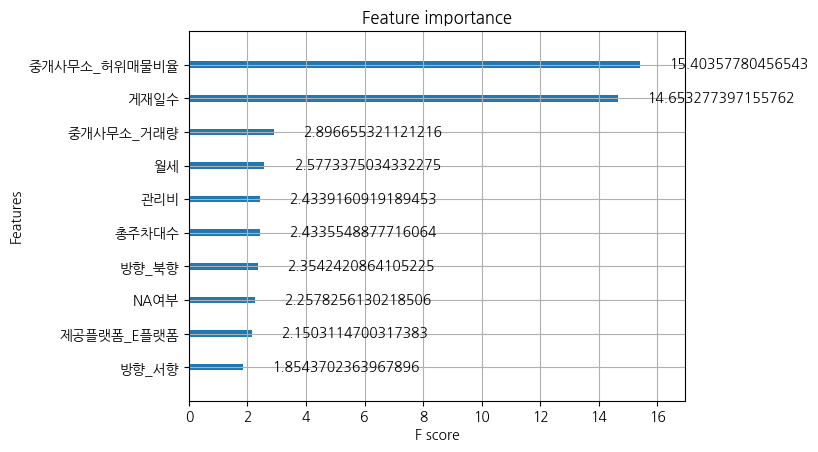

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_model, importance_type="gain", max_num_features=10)
plt.show()

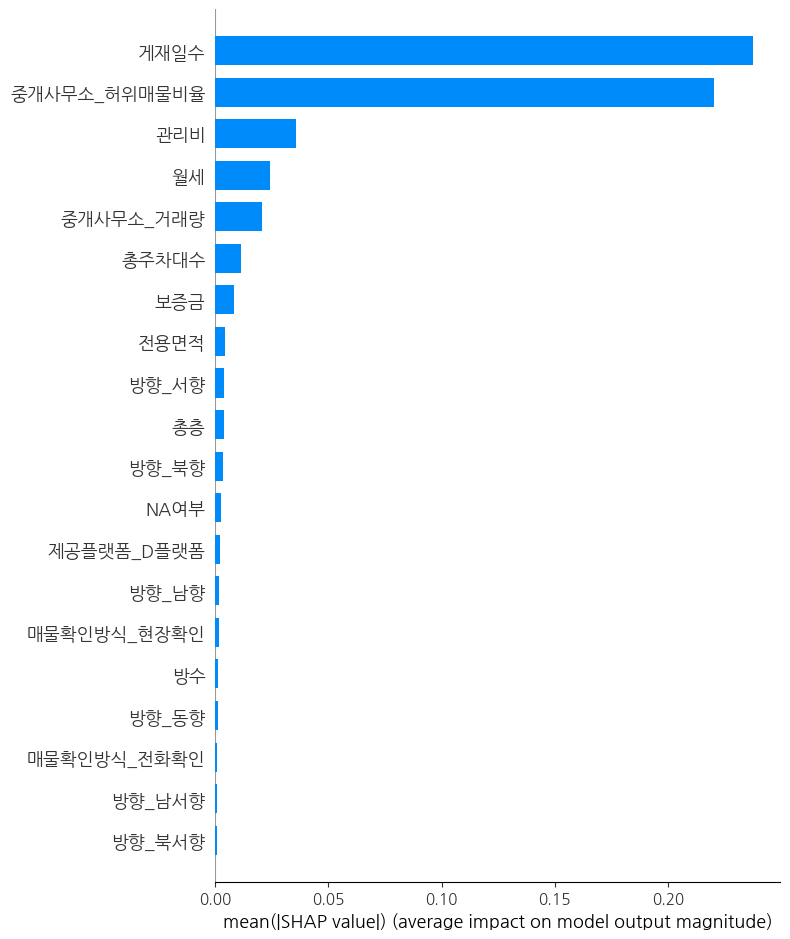

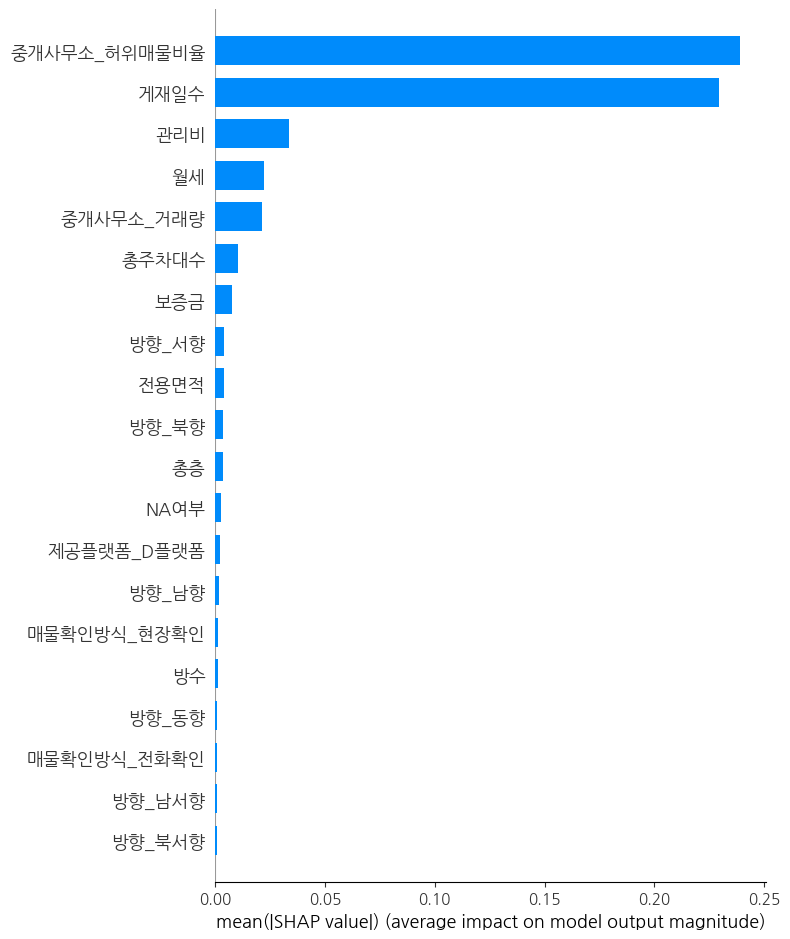

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


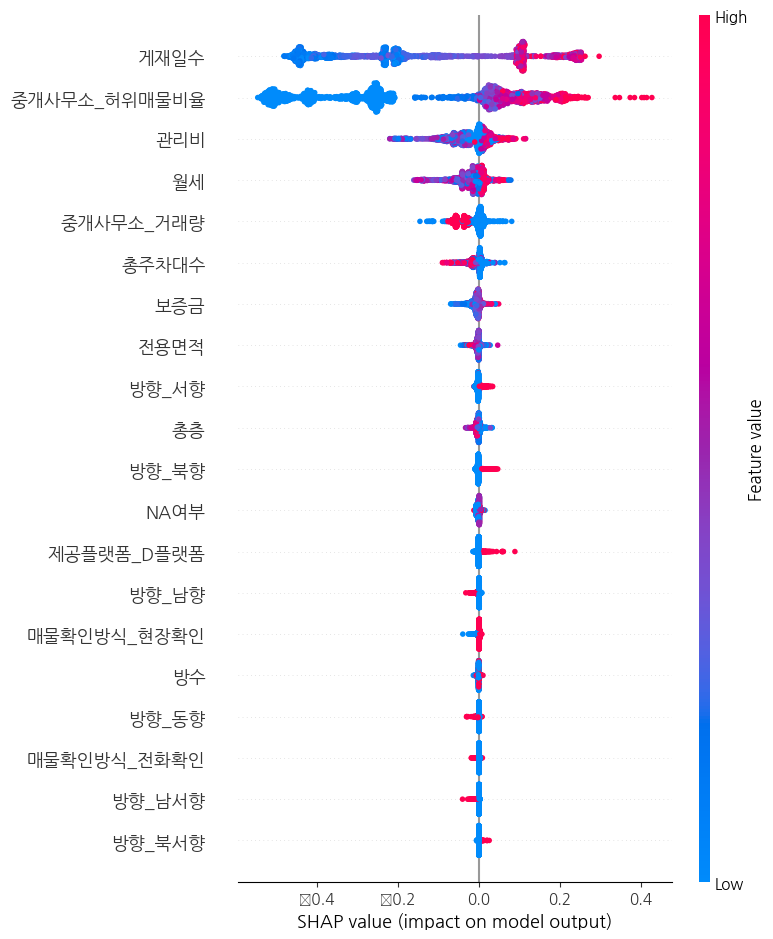

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


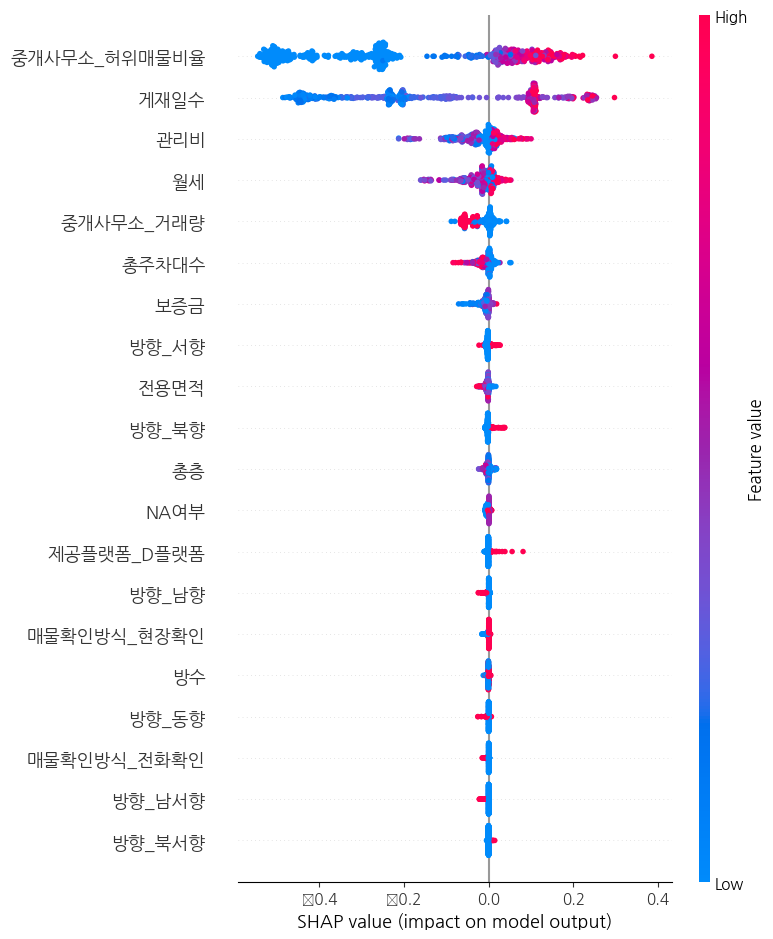

In [ ]:
# Shap value

import shap

# 최종 모델(final_model)과 DMatrix 형태의 데이터를 있다고 가정
# final_model: xgb.train()으로 학습한 최종 모델
# dtrain_full: 전체 train 데이터의 DMatrix
# X_train_full: 전체 train 데이터 (Pandas DataFrame)
# dtest: 테스트 데이터 DMatrix
# X_test: 테스트 데이터 (Pandas DataFrame)

# 1. Train 데이터에 대한 SHAP 값 계산 및 시각화
explainer_train = shap.Explainer(final_model)
shap_values_train = explainer_train(X)

# 2. Test 데이터에 대한 SHAP 값 계산 및 시각화
explainer_test = shap.Explainer(final_model)
shap_values_test = explainer_test(test)

shap.summary_plot(shap_values_train, X, plot_type="bar")
shap.summary_plot(shap_values_test, test, plot_type="bar")
shap.summary_plot(shap_values_train, X)
shap.summary_plot(shap_values_test, test)

# (선택) 특정 샘플에 대한 Force Plot
# shap.initjs()
# shap.force_plot(explainer_test.expected_value, shap_values_test[0,:], X_test.iloc[0,:])